<a href="https://colab.research.google.com/github/matalhim/mephi/blob/master/model_eas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np

data = np.fromfile('p1630_2022.dat', dtype=np.float32)

count = 0
for i in range(len(data) - 1, -1, -1):
    if data[i] == 30:
        count += 1
        i_start = i

print(count)

print(len(data))
def split_list(lst, n):
    size = len(lst) // 500
    return [lst[i * size: (i + 1) * size] for i in range(n)]
n = 500
result = split_list(data, n)
print(len(result))
# print(data[i_start-5])
# print('event number: ', data[i_start-5])
# print('theta: ', data[i_start])
# print('phi: ', data[i_start+1])
# all_times = data[i-144:i+1]
# print(data[-145:])
print(result[0][5])

500
881000
500
30.0


In [181]:
events_cluster_times = []
model_theta = []
model_phi = []
for event in result:
    model_theta.append(event[5])
    model_phi.append(event[6])
    all_times = event[-145:-1]
    times = []
    for i in range(1, len(all_times), 4):
        times.append(all_times[i])
    cluster_times = [times[i:i+4] for i in range(0, len(times), 4)]

    cluster_times_dict = [{'ds_{}'.format(j+1): times[i:i+4][j] for j in range(len(times[i:i+4]))} for i in range(0, len(times), 4)]
    events_cluster_times.append(cluster_times_dict)
print(len(events_cluster_times))

500


##Кластерный метод (Метод сопряжённых градиентов)

In [182]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import json
C = 0.299792458

def calculate_functional(vars, times, x, y):
    a, b, d = vars
    f = np.sum((np.array(times) * C - np.array(x) * a - np.array(y) * b - d) ** 2)
    return f

def cluster_method(event_num, num, cluster_times):
    num_cluster = num
    cluster_dict = cluster_times

    df = pd.read_csv('coordinates_data.csv', sep='\\s+')
    cluster_data = {}
    for index, row in df.iterrows():
        cluster = row['cluster']
        x = row['x']
        y = row['y']
        if cluster in cluster_data:
            cluster_data[cluster]['x'].append(x)
            cluster_data[cluster]['y'].append(y)
        else:
            cluster_data[cluster] = {'x': [x], 'y': [y]}

    x_list = cluster_data[num_cluster]['x']
    x_values = []
    y_list = cluster_data[num_cluster]['y']
    y_values = []
    ds_times = []
    for ds_i, time in cluster_dict.items():
        i = int(ds_i.split("_")[1])
        x_values.append(x_list[i-1])
        y_values.append(y_list[i-1])
        ds_times.append(time)


    ds_delta_times = [ds_time - min(ds_times) for ds_time in ds_times]
    len_list = len(ds_delta_times)
    i = 0
    for i in range(len(ds_delta_times)):
        if ds_delta_times[i] == 0:
            first_i = i
            first_ds_x = x_values[i]
            first_ds_y = y_values[i]
    i = 0
    while i < len_list:
        d = np.sqrt((x_values[i] - first_ds_x) ** 2 +
                    (y_values[i] - first_ds_y) ** 2)
        if ds_delta_times[i] > d / C:
            with open("ds_errors.txt", "a") as file:
                file.write('Номер события: {}'.format(event_num))
                file.write('кластер:{}, первая станция: {}, неправильная: {}\n'.format(num_cluster, first_i + 1, i + 1))
                file.write('разница времени срабатывания: {}\n'.format(ds_delta_times[i]))
                file.write('Расстояние между станциями: {}\n'.format(d))
                file.write('координаты станций: {}\n{}\n\n'.format([first_ds_x, first_ds_y], [x_values[i], y_values[i]]))
            del x_values[i]
            del y_values[i]
            del ds_delta_times[i]
            len_list -= 1
            if len_list == 2:
                return None, None
        else:
            i += 1

    a0 = np.array([0, 0, 0])
    result = minimize(calculate_functional, a0, args=(ds_delta_times, x_values, y_values), method='CG')
    c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
    n = [-result.x[0], -result.x[1], -c]
    len_n = np.linalg.norm(n)

    theta_rad = np.arccos(n[2] / round(len_n, 0))
    theta_deg = np.degrees(theta_rad)

    phi_rad = np.arctan2(n[1], n[0])
    phi_deg = np.degrees(phi_rad)
    if phi_deg < 0:
        phi_deg = 360 + phi_deg

    return theta_deg, phi_deg


In [183]:
def average_value(x):
    return sum(x) / len(x)

average_theta = []
average_phi = []

for j in range(len(events_cluster_times)):
    theta_values = []
    phi_values = []
    for i in range(len(events_cluster_times[j])):
        theta, phi = cluster_method(j, i+1, events_cluster_times[j][i])
        if theta is not None:
            theta_values.append(theta)
            phi_values.append(phi)

    average_theta.append(average_value(theta_values))
    average_phi.append(average_value(phi_values))



<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1] ** 2)
<ipython-input-182-a218cb33d834>:70: RuntimeWarning: invalid value encountered in sqrt
  c = - np.sqrt(1 - result.x[0] ** 2 - result.x[1

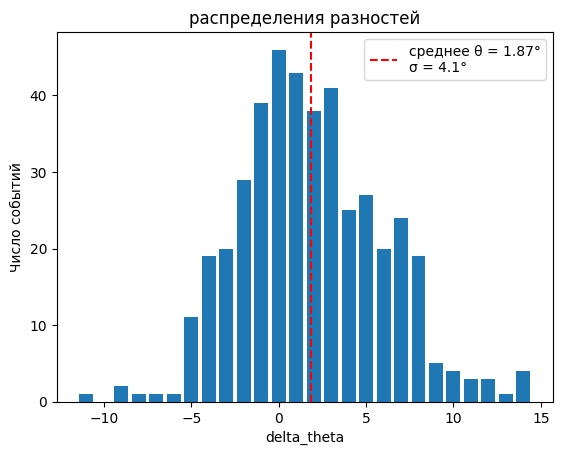

In [184]:
import matplotlib.pyplot as plt

delta_theta = [average_theta[i] - 30 for i in range(len(average_theta)) if not np.isnan(average_theta[i])]

std_deviation_cluster_theta = np.std(delta_theta)
mean_cluster_theta = np.mean(delta_theta)

delta_theta = [round(delta, 0) for delta in delta_theta]

delta_phi = [round(average_phi[i] - model_phi[i], 0) for i in range(len(average_phi)) if not np.isnan(average_phi[i])]
plt.hist(delta_theta, bins=np.arange(min(delta_theta), max(delta_theta) + 1), align='left', rwidth=0.8)
plt.axvline(x=mean_cluster_theta, color='r', linestyle='--', label='среднее θ = {}°\nσ = {}°'.format(round(mean_cluster_theta, 2), round(std_deviation_cluster_theta, 2)))
plt.legend()
plt.xlabel('delta_theta')
plt.ylabel('Число событий')
plt.title('распределения разностей')
plt.show()

##Классический метод

In [158]:
C = 0.299792458
def calculate_functional_classic(vars, times, x, y, z):
    a, b, c, d = vars
    f = np.sum((np.array(times) * C - np.array(x) * a - np.array(y) * b - np.array(z) * c - d) ** 2)
    f += (a ** 2 + b ** 2 + c ** 2 - 1) ** 2
    return f

def classic_method(event_num, cluster_times_list):
    num_clusters = [i+1 for i in range(9)]
    cluster_dict = cluster_times_list

    df = pd.read_csv('coordinates_data.csv', delim_whitespace=True)
    cluster_data = {}
    for index, row in df.iterrows():
        cluster = row['cluster']
        x = row['x']
        y = row['y']
        z = row['z']
        if cluster in cluster_data:
            cluster_data[cluster]['x'].append(x)
            cluster_data[cluster]['y'].append(y)
            cluster_data[cluster]['z'].append(z)
        else:
            cluster_data[cluster] = {'x': [x], 'y': [y], 'z': [z]}



    x_values = []
    y_values = []
    z_values = []
    ds_times = []

    for j in range(len(num_clusters)):
        x_list = cluster_data[num_clusters[j]]['x']
        y_list = cluster_data[num_clusters[j]]['y']
        z_list = cluster_data[num_clusters[j]]['z']
        for ds_i, time in cluster_dict[j].items():
            i = int(ds_i.split("_")[1])
            x_values.append(x_list[i-1])
            y_values.append(y_list[i-1])
            z_values.append(z_list[i-1])
            ds_times.append(time)


    ds_delta_times = [round(ds_time - min(ds_times), 3) for ds_time in ds_times]
    len_list = len(ds_delta_times)

    for i in range(len(ds_delta_times)):
        if ds_delta_times[i] == 0:
            first_i = i
            first_ds_x = x_values[i]
            first_ds_y = y_values[i]
            first_ds_z = z_values[i]
    i = 0
    while i < len_list:
        d = np.sqrt( (x_values[i] - first_ds_x) ** 2 +
                    (y_values[i] - first_ds_y) ** 2 +
                    (z_values[i] - first_ds_z) ** 2)
        if ds_delta_times[i] > d / C:
            with open("ds_errors_classic.txt", "a") as file:
                file.write('Номер события: {}, '.format(event_num))
                file.write('первая станция: {}, неправильная: {}\n'.format(first_i + 1, i + 1))
                file.write('разница времени срабатывания: {}\n'.format(ds_delta_times[i]))
                file.write('Расстояние между станциями: {}\n'.format(d))
                file.write('координаты станций: {}\n{}\n\n'.format([first_ds_x, first_ds_y, first_ds_z], [x_values[i], y_values[i], z_values[i]]))
            del ds_delta_times[i]
            del x_values[i]
            del y_values[i]
            del z_values[i]
            len_list -= 1
        else:
            i += 1



    a0 = np.array([0, 0, 0, 0])
    result = minimize(calculate_functional_classic, a0, args=(ds_delta_times, x_values, y_values, z_values), method='CG')
    n = [-result.x[0], -result.x[1], -result.x[2]]
    len_n = np.linalg.norm(n)

    theta_rad = np.arccos(n[2] / len_n)
    theta_deg = np.degrees(theta_rad)

    phi_rad = np.arctan2(n[1], n[0])
    phi_deg = np.degrees(phi_rad)
    if phi_deg < 0:
        phi_deg = 360 + phi_deg
    return theta_deg, phi_deg

In [159]:
classic_method_theta = []
classic_method_phi = []

for i in range(len(events_cluster_times)):
    theta, phi = classic_method(i, events_cluster_times[i])
    if theta is not None:
        classic_method_theta.append(theta)
        classic_method_phi.append(phi)


<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid value encountered in scalar divide
  theta_rad = np.arccos(n[2] / len_n)
<ipython-input-158-72bfb3976f48>:81: RuntimeWarning: invalid v

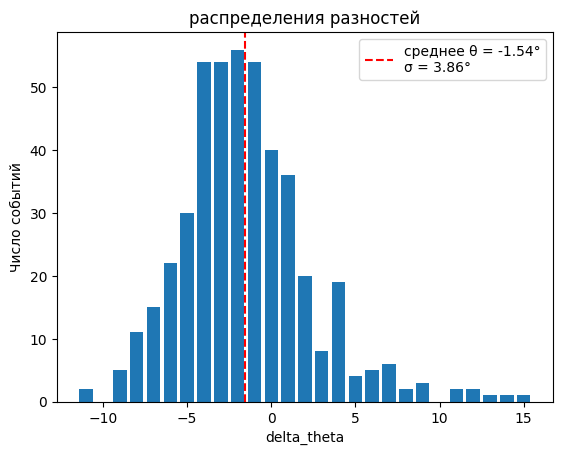

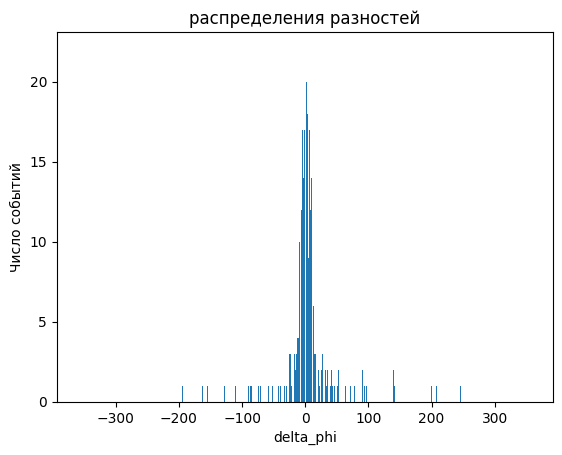

In [185]:
classic_delta_theta = [classic_method_theta[i] - 30 for i in range(len(classic_method_theta)) if not np.isnan(classic_method_theta[i])]

std_deviation_classic_theta = np.std(classic_delta_theta)
mean_classic_theta = np.mean(classic_delta_theta)


classic_delta_theta = [round(delta, 0) for delta in classic_delta_theta]
plt.hist(classic_delta_theta, bins=np.arange(min(classic_delta_theta), max(classic_delta_theta) + 1), align='left', rwidth=0.8)
plt.axvline(x=mean_classic_theta, color='r', linestyle='--', label='среднее θ = {}°\nσ = {}°'.format(round(mean_classic_theta, 2), round(std_deviation_classic_theta, 2)))
plt.legend()
plt.xlabel('delta_theta')
plt.ylabel('Число событий')
plt.title('распределения разностей')
plt.show()

classic_delta_phi = [round(classic_method_phi[i] - model_phi[i], 0) for i in range(len(classic_method_phi)) if not np.isnan(classic_method_phi[i])]
plt.hist(delta_phi, bins=np.arange(min(classic_delta_phi), max(classic_delta_phi) + 1), align='left', rwidth=0.8)
plt.xlabel('delta_phi')
plt.ylabel('Число событий')
plt.title('распределения разностей')
plt.show()